In [1]:
import os
import pandas as pd
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import chromosomeDefinition as cd
import analyseVCF as aVCF
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

In [2]:
CNV_COLUMNS = ['chrom','posStart','posEnd','copyNum','gainOrLoss','BAF','score','germlineOrSomatic','oneOrZero']

In [3]:
# LOAD BED
BED_PATH = "/Users/peterpriestley/hmf/analyses/slices/"
BED_FILE_NAME = "cosmicCurated.bed" 
BED_FILE_NAME = "cosmicCancerCensus.bed"
#BED_FILE_NAME = "CPCT_Slicing.bed"
USE_BED = True
LOAD_FULL_FILE = True

### FUNCTIONS

In [4]:
def findFiles(path,suffix):
    files=[]
    for x in os.listdir(path):
        if x[-len(suffix):] == suffix:
            files.append(x)
    return files

In [5]:
def loadCNVforPatient(cnvFile,patientName):
    dfCNV = pd.read_table(cnvFile, names = CNV_COLUMNS )
    #print dfCNV
    #add regions with default copy number
    last = dfCNV.iloc[0]
    for i in range(1, dfCNV.shape[0]-1):
        #print last.chrom,last.posStart,last.posEnd
        if last['posEnd']<>dfCNV.iloc[i]['posStart']:
            if last['chrom']==dfCNV.iloc[i]['chrom']:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], dfCNV.iloc[i]['posStart']-1,2,'none','-','-','-','-']
            else:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], cd.chromosomeLength[last['chrom']],2,'none','-','-','-','-']
                if dfCNV.iloc[i]['posStart']<>0:
                    dfCNV.loc[len(dfCNV)] = [dfCNV.iloc[i]['chrom'],0, dfCNV.iloc[i]['posStart'],2,'none','-','-','-','-']
        last = dfCNV.iloc[i]
    #fix first record
    if dfCNV.iloc[0]['posStart']<>0:
        dfCNV.loc[len(dfCNV)] = ['1',0, dfCNV.iloc[0]['posStart'],2,'none','-','-','-','-']
    #Additional Fields
    dfCNV['chromPos']= dfCNV['chrom'].apply(lambda x: cd.intChrom(x)) + dfCNV['posStart'] / dfCNV['chrom'].apply(lambda x: cd.chromosomeLength[str(x)])
    dfCNV['chrom'] = dfCNV['chrom'].apply(lambda x: cd.intChrom(x))
    dfCNV['cappedCopyNum'] = dfCNV['copyNum'].clip(upper=5)
    dfCNV = dfCNV.sort_values(["chrom","posStart","posEnd"]).reset_index()
    dfCNV['regionLength'] = (dfCNV['posEnd']-dfCNV['posStart'])
    dfCNV['patientName']=patientName
    return dfCNV

In [6]:
def calculateSomaticCNV(dfTumorCNV):
    lastSomaticCopyNum = 2
    dfTumorCNV['copyNumSomatic']= dfTumorCNV['copyNum']
    for i in range(1, dfTumorCNV.shape[0]-1):
        if dfTumorCNV.iloc[i].germlineOrSomatic=="germline":
                dfTumorCNV.ix[i,'copyNumSomatic'] = lastSomaticCopyNum
        elif dfTumorCNV.iloc[i].germlineOrSomatic=="somatic"  or dfTumorCNV.iloc[i].germlineOrSomatic=="-":  
            lastSomaticCopyNum = dfTumorCNV.ix[i,'copyNumSomatic']
    return dfTumorCNV

In [7]:
def calculateCleanCNV(dfTumorCNV):
    lastSomaticCopyNum = 2
    dfTumorCNV['copyNumClean']= dfTumorCNV['copyNum']
    for i in range(1, dfTumorCNV.shape[0]-1):
        if (dfTumorCNV.iloc[i].normalRatio < 0.7 and dfTumorCNV.iloc[i].gainOrLoss=='loss' and dfTumorCNV.iloc[i].tumorRatio/dfTumorCNV.iloc[i].normalRatio>0.1) or \
            (dfTumorCNV.iloc[i].normalRatio>1.4 and dfTumorCNV.iloc[i].gainOrLoss=='gain' and dfTumorCNV.iloc[i].tumorRatio/dfTumorCNV.iloc[i].normalRatio<1.4) or \
            dfTumorCNV.iloc[i].germlineOrSomatic=="germline":
                dfTumorCNV.ix[i,'copyNumClean'] = lastSomaticCopyNum
        elif dfTumorCNV.iloc[i].germlineOrSomatic=="somatic" or dfTumorCNV.iloc[i].germlineOrSomatic=="-":  
            lastSomaticCopyNum = dfTumorCNV.ix[i,'copyNumClean']
    return dfTumorCNV

In [8]:
def cleanNONBAFregionsCNV(dfTumorCNV):
    ### LOGIC
    # If regionLength < x 
    # AND BAF = "-" 
    # AND previous and next adjacent regions have the same cleaned copy number 
    # AND the copyNum <> previous Copy NUM and 
    # AND copyNUM BETWEEN previousCopyNUM +/- 51%
    # THEN REMOVE REGION AND MAKE ALL 3 REGIONS ONE REGION.
    lastCleanCopyNum = 2
    lastChrom = 1
    dfTumorCNV['copyNumCleanNonBAFRemoved']= dfTumorCNV['copyNumClean']
    for i in range(1, dfTumorCNV.shape[0]-1):
        if lastChrom <> dfTumorCNV.iloc[i].chrom:
            lastCleanCopyNum = 2
            lastChrom = dfTumorCNV.ix[i,'chrom']
        elif ((dfTumorCNV.iloc[i].BAF == "-" or dfTumorCNV.iloc[i].nonZeroCount < 20) and \
            dfTumorCNV.iloc[i].copyNumClean<lastCleanCopyNum*1.35 and dfTumorCNV.iloc[i].copyNumClean > lastCleanCopyNum*0.65) \
            or (dfTumorCNV.iloc[i].nonZeroCount < 10 and dfTumorCNV.iloc[i].copyNumClean<lastCleanCopyNum*1.51 and \
            dfTumorCNV.iloc[i].copyNumClean > lastCleanCopyNum*0.49) \
            or (dfTumorCNV.iloc[i].nonZeroCount < 100 and \
            (dfTumorCNV.iloc[i].ratioOfRatio*2<lastCleanCopyNum*1.25 and dfTumorCNV.iloc[i].ratioOfRatio*2> lastCleanCopyNum*0.8)) \
            or abs(lastCleanCopyNum-dfTumorCNV.iloc[i].ratioOfRatio*2) < abs(dfTumorCNV.iloc[i].copyNumClean-dfTumorCNV.iloc[i].ratioOfRatio*2):
#            or (dfTumorCNV.iloc[i].ratioOfRatio*2 <lastCleanCopyNum and lastCleanCopyNum < dfTumorCNV.iloc[i].copyNumClean) \
#            or (dfTumorCNV.iloc[i].ratioOfRatio*2 >lastCleanCopyNum and lastCleanCopyNum > dfTumorCNV.iloc[i].copyNumClean) ):
                dfTumorCNV.ix[i,'copyNumCleanNonBAFRemoved'] = lastCleanCopyNum
        elif dfTumorCNV.iloc[i].germlineOrSomatic=="somatic" or dfTumorCNV.iloc[i].germlineOrSomatic=="-": 
            lastCleanCopyNum = dfTumorCNV.ix[i,'copyNumCleanNonBAFRemoved']
            lastChrom = dfTumorCNV.ix[i,'chrom']
    return dfTumorCNV

In [9]:
def positionChart(dfCNV,filename,fieldName,minChrom=1,maxChrom=23,maxValue=10):
    plt.figure(figsize=[18,3])
    plt.title(filename+" "+fieldName)
    ax = plt.gca()
    ax.plot(dfCNV['chromPos'], dfCNV[fieldName],drawstyle="steps-post")
    ax.axis([minChrom, maxChrom, 0, maxValue])

In [10]:
def pdfChart(log_dens,maxYValue=8):
    fig, ax = plt.subplots()
    ax.plot(X_plot[:, 0], np.exp(log_dens), '-',
            label="kernel = '{0}'".format('gaussian'))
    ax.legend(loc='upper right')
    fig.set_figwidth(10)
    fig.set_figheight(5)
    #ax.set_xlim(0, 1)
    ax.set_ylim(-0.02, maxYValue)
    ax.grid(b=True, which='both', color='0.65',linestyle='-')
    plt.show()

In [11]:
def cnvLabel(copyNumber):
    if copyNumber < 2:
        return 'loss'
    elif copyNumber > 2:
        return 'amplification'
    else:
        return'normal'

In [12]:
def nonZeroCountBetween(chrom,minPos,maxPos):
    temp = dfTumorRatio[(dfTumorRatio.Chromosome==chrom)&(dfTumorRatio.Start>minPos)&\
                       (dfTumorRatio.Start<maxPos)&(dfTumorRatio.Ratio_x<>-1)]
    return temp['Start'].count(),temp['Ratio_x'].mean(),temp['Ratio_y'].mean(),temp['MedianRatio_x'].mean(),temp['MedianRatio_y'].mean()

In [50]:
def fitBAFPeak(mBAF):
    return min(mBAFPeaks, key=lambda x:abs(x-mBAF))

In [49]:
def fitCNVPeak(ratio):
    return min(cnvPeaks, key=lambda x:abs(x-ratio))

In [13]:
def runGeneCNVAnalysis(dfCNV,bed,patientName):
    geneList =[]
    for bedrow in bed:
        bedChromPosStart = cd.intChrom(bedrow[0]) + float(bedrow[1])/cd.chromosomeLength[bedrow[0]]
        bedChromPosEnd = cd.intChrom(bedrow[0]) + float(bedrow[1])/cd.chromosomeLength[bedrow[0]]
        prevCNV = max(dfCNV[(dfCNV['chromPos'] < bedChromPosStart)].index.tolist())
        if dfCNV[(dfCNV['chromPos'] > bedChromPosEnd) ].index.tolist():
            nextCNV = min(dfCNV[(dfCNV['chromPos'] > bedChromPosEnd) ].index.tolist())
            minCopyNum = min(([dfCNV.iloc[x]['copyNum']]) for x in range (prevCNV,nextCNV)) 
        else:
            minCopyNum = [-1]
        geneList.append([patientName,bedrow[3],bedrow[0],bedrow[1],bedrow[2],minCopyNum[0],cnvLabel(minCopyNum[0])])
    return geneList

In [14]:
def patientIDFromFilename(filename):
    patientIDStart = filename.find("CPCT02")
    return filename[patientIDStart:patientIDStart+12]

In [15]:
def loadBAFData(bafFile):
    df = pd.read_table(bafFile)
    return df

In [16]:
def loadVCF(path,filename,sampleNames,patientID):
    df = pd.DataFrame()
    if USE_BED:
        bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
        return pd.concat([df,aVCF.loadVariantsFromVCF(path,filename,sampleNames,patientID,True,True,bed,LOAD_FULL_FILE)])
    else:
        return pd.concat([df,aVCF.loadVariantsFromVCF(path,filename,sampleNames,patientID,True)])

In [17]:
def calculateMBAFBetween(chrom,minPos,maxPos):
    dftemp = dfBAF[(dfBAF.Chromosome==chrom)&(dfBAF.Position>minPos)&(dfBAF.Position<maxPos)]
    return dftemp['mBAF'].median(),dftemp['mBAF'].count()

In [18]:
def createBAF(dfGermline):
    dfBAF = dfGermline[(dfGermline['variantType']=="SNP")&(dfGermline['normalSGT']=="0/1")&(dfGermline['normalAF']>0.4) \
                   &(dfGermline['normalAF']<0.65)&(dfGermline['normalDP']>30)&\
                   (dfGermline['normalDP']<40)][['chrom','pos','tumorAF']]
    dfBAF.columns = ['Chromosome', 'Position','BAF']
    dfBAF['Position'] = pd.to_numeric(dfBAF['Position'])
    dfBAF['mBAF']= 0.5+abs(dfBAF['BAF']-0.5)
    dfBAF['chromPos']= dfBAF['Chromosome'].apply(lambda x: cd.intChrom(x)) + dfBAF['Position'] / dfBAF['Chromosome'].apply(lambda x: cd.chromosomeLength[str(x)])
    dfBAF['Chromosome']= dfBAF['Chromosome'].apply(lambda x: cd.intChrom(x))
    return dfBAF

In [41]:
def findPeaks(log_dens,X_range):
    peaks = []
    troughs = []
    dens=np.exp(log_dens)
    diff = [dens[x] - dens[x-1] for x in range(1,len(dens))]
    for i in range (len(diff)-1):
        if diff[i+1] < 0 and diff[i] > 0:
            peaks.append(float(i+1)/len(dens)*X_range)
        if diff[i+1] > 0 and diff[i] < 0:
            troughs.append(float(i+1)/len(dens)*X_range)
    return peaks#, troughs

### ANALYSIS

In [20]:
PATH="/Users/peterpriestley/hmf/analyses/v1.12samples/CPCT02020444/"
tumorCNVFileName=findFiles(PATH,"gz_CNVs")[0]
normalCNVFileName=findFiles(PATH,"normal_CNVs")[0]
tumorRatioFileName=findFiles(PATH,"gz_ratio.txt")[0]
normalRatioFileName=findFiles(PATH,"gz_normal_ratio.txt")[0]
germlineVCFFilename = findFiles(PATH,"SLICED.vcf")[0]
patientID = patientIDFromFilename(germlineVCFFilename)
print "germline =",germlineVCFFilename
print "patient =",patientID
print "CNV =",tumorCNVFileName

germline = 170305_HMFregCPCT_FR10246697_FR13979991_CPCT02020444.annotatedSLICED.vcf
patient = CPCT02020444
CNV = CPCT02020444T_dedup.realigned.pileup.gz_CNVs


In [21]:
dfGermline = loadVCF(PATH,germlineVCFFilename,{patientID+'R':'normal',patientID+'T':'tumor'},patientID)

reading vcf file: 170305_HMFregCPCT_FR10246697_FR13979991_CPCT02020444.annotatedSLICED.vcf
reading VCF File line: 1
reading VCF File line: 200001
Number variants loaded: 344398


In [22]:
dfBAF = createBAF(dfGermline)

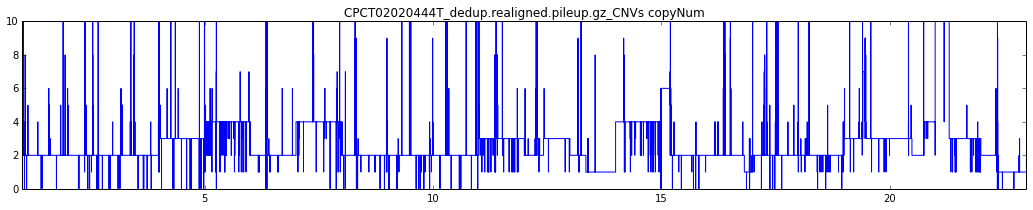

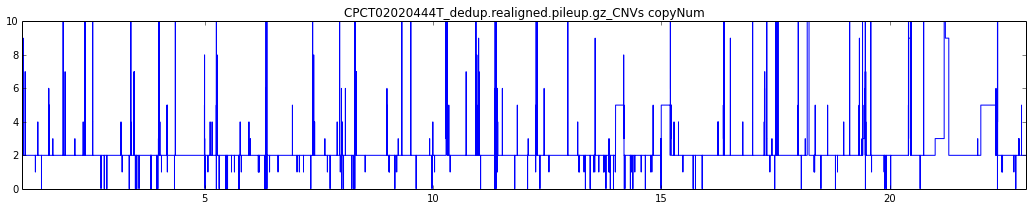

In [24]:
patientName=normalCNVFileName[:12]
dfTumorCNV = loadCNVforPatient(PATH+tumorCNVFileName,patientName)
dfNormalCNV = loadCNVforPatient(PATH+normalCNVFileName,patientName)
positionChart(dfTumorCNV,tumorCNVFileName,"copyNum")
positionChart(dfNormalCNV,tumorCNVFileName,"copyNum")


In [25]:
dfTumorCNV['mBAF'], dfTumorCNV['mBAFCount'] = \
    np.vectorize(calculateMBAFBetween)(dfTumorCNV['chrom'], dfTumorCNV['posStart'],dfTumorCNV['posEnd'])

### Detailed Ratio Analysis

In [27]:
dfTumorRatio = pd.read_table(PATH + tumorRatioFileName, header=0)#names = ['chrom','window',"ratio","segmentRatio","copyNum","mbaf","baf","GT","uncertainty"] )
dfNormalRatio = pd.read_table(PATH + normalRatioFileName, header=0)# names = ['chrom','window',"ratio","segmentRatio","copyNum","mbaf","baf","GT","uncertainty"] )
dfTumorRatio.set_index(['Chromosome','Start'],inplace=True)
dfNormalRatio.set_index(['Chromosome','Start'],inplace=True)
dfTumorRatio = pd.merge(dfTumorRatio,dfNormalRatio,how='inner', left_index=True,right_index=True)
#dfTumorRatio = dfTumorRatio[(dfTumorRatio.Ratio_y > 0)]
dfTumorRatio['ratio']= pd.to_numeric(dfTumorRatio['Ratio_x'],errors=coerce) /pd.to_numeric(dfTumorRatio['Ratio_y'],errors=coerce)
dfTumorRatio = dfTumorRatio.reset_index()
dfTumorRatio['chromPos'] = dfTumorRatio['Chromosome'].apply(lambda x: cd.intChrom(str(x))) + \
    dfTumorRatio['Start']/dfTumorRatio['Chromosome'].map(lambda x: cd.chromosomeLength[str(x)])
dfTumorRatio['Chromosome'] = dfTumorRatio['Chromosome'].apply(lambda x: cd.intChrom(str(x)))

/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
#dfTumorRatio[(dfTumorRatio.CopyNumber_x<>2)&(dfTumorRatio.CopyNumber_y==2)&(dfTumorRatio.Ratio_x>0)]\
#[['Chromosome','Start','CopyNumber_x','Ratio_x','Ratio_y','MedianRatio_x','MedianRatio_y','ratio']].head(1)

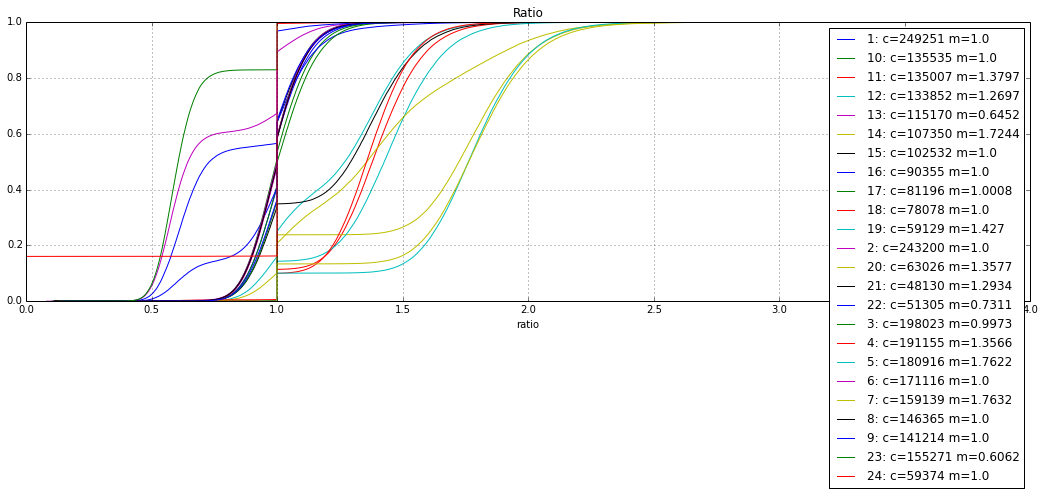

In [29]:
chromosomes = dfTumorRatio['Chromosome'].unique()
for chromosome in chromosomes:
    ser = dfTumorRatio[dfTumorRatio.Chromosome==chromosome]['ratio'] / 1
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=str(chromosome)+": c="+str(ser.count())+" m="+str(round(ser.median(),4)))
    ser_cdf.plot(drawstyle='steps',legend=True, title="Ratio",figsize=[18,5],xlim=[0,4],ylim=[0,1],grid=True)

In [31]:
dfTumorCNV['nonZeroCount'],dfTumorCNV['tumorRatio'],dfTumorCNV['normalRatio'] \
    ,dfTumorCNV['tumorMedianRatio'],dfTumorCNV['normalMedianRatio'] = \
    np.vectorize(nonZeroCountBetween)(dfTumorCNV['chrom'], dfTumorCNV['posStart'],dfTumorCNV['posEnd'])
dfTumorCNV['ratioOfRatio']=dfTumorCNV.tumorRatio/dfTumorCNV.normalRatio

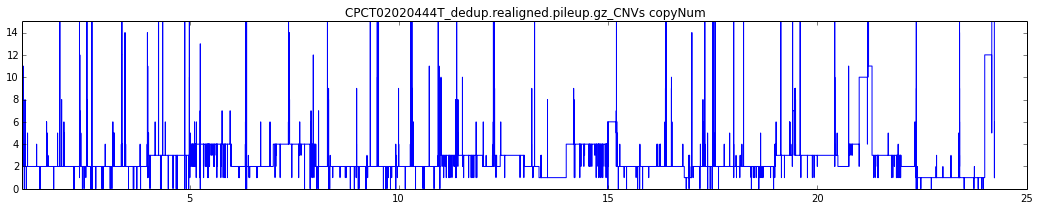

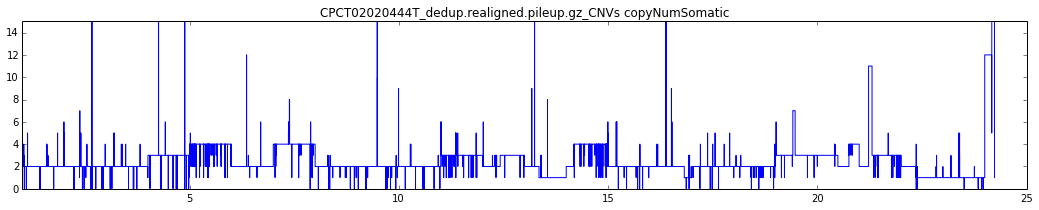

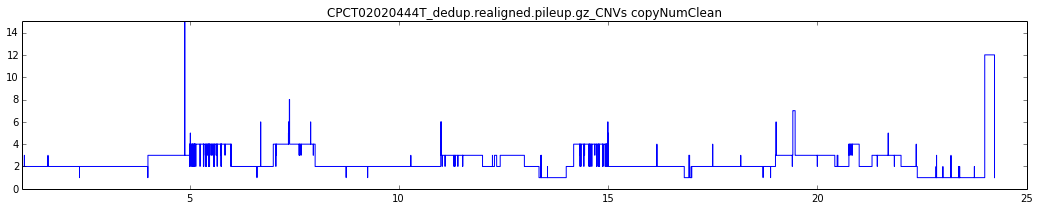

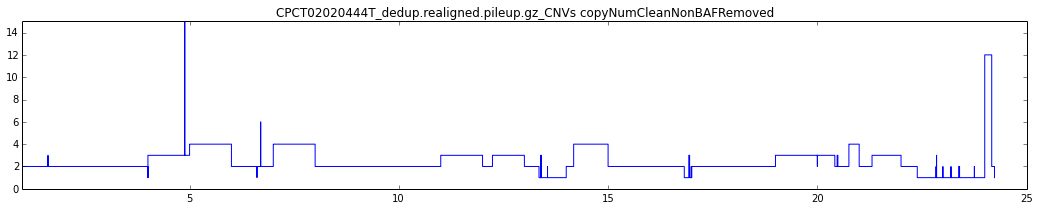

In [32]:
dfTumorCNV = calculateSomaticCNV(dfTumorCNV)
dfTumorCNV = calculateCleanCNV(dfTumorCNV)
dfTumorCNV = cleanNONBAFregionsCNV(dfTumorCNV)
positionChart(dfTumorCNV,tumorCNVFileName,"copyNum",1,25,15)
positionChart(dfTumorCNV,tumorCNVFileName,"copyNumSomatic",1,25,15)
positionChart(dfTumorCNV,tumorCNVFileName,"copyNumClean",1,25,15)
positionChart(dfTumorCNV,tumorCNVFileName,"copyNumCleanNonBAFRemoved",1,25,15)

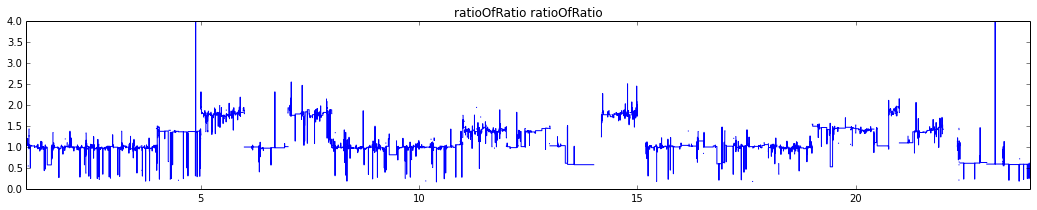

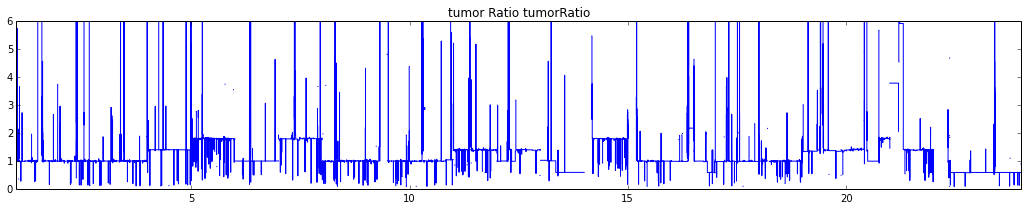

In [35]:
positionChart(dfTumorCNV,"ratioOfRatio","ratioOfRatio",1,24,4)
positionChart(dfTumorCNV,"tumor Ratio","tumorRatio",1,24,6)

In [33]:
dfTumorCNV[(((dfTumorCNV.normalRatio<0.7)&(dfTumorCNV.gainOrLoss=='loss')&(dfTumorCNV.tumorRatio/dfTumorCNV.normalRatio>0.3)) | \
            ((dfTumorCNV.normalRatio>1.4)&(dfTumorCNV.gainOrLoss=='gain')&(dfTumorCNV.tumorRatio/dfTumorCNV.normalRatio<10))) \
          & (dfTumorCNV.germlineOrSomatic == 'somatic')& (dfTumorCNV.copyNum <>2)& (dfTumorCNV.chrom==19)].sort_values('ratioOfRatio')

,index,chrom,posStart,posEnd,copyNum,gainOrLoss,BAF,score,germlineOrSomatic,oneOrZero,chromPos,cappedCopyNum,regionLength,patientName,mBAF,mBAFCount,nonZeroCount,tumorRatio,normalRatio,tumorMedianRatio,normalMedianRatio,ratioOfRatio,copyNumSomatic,copyNumClean,copyNumCleanNonBAFRemoved
2400,1826,19,12694000,12699000,1,loss,A,-1,somatic,0,19.214683,1,5000,CPCT02020444,NaN,0,5,0.539034,0.532659,0.522592,0.925272,1.011968,1,3,3
2459,1884,19,54556000,54561000,1,loss,A,-1,somatic,0,19.922661,1,5000,CPCT02020444,NaN,0,5,0.514255,0.500944,0.520607,0.929283,1.026571,1,3,3
2394,1820,19,8410000,8415000,1,loss,A,-1,somatic,0,19.142231,1,5000,CPCT02020444,NaN,0,5,0.548839,0.448439,0.482839,0.905725,1.223887,1,3,3
2422,1847,19,27792000,27837000,4,gain,-,-1,somatic,0,19.470023,4,45000,CPCT02020444,NaN,0,37,2.709776,2.027400,1.988350,1.983468,1.336577,4,3,3
2419,1844,19,27741000,27767000,4,gain,-,-1,somatic,0,19.469161,4,26000,CPCT02020444,NaN,0,19,2.279014,1.627254,2.040480,1.654978,1.400527,4,4,3
2390,1816,19,879000,880000,6,gain,-,-1,somatic,0,19.014866,5,1000,CPCT02020444,NaN,0,1,3.013720,1.969130,3.013720,0.882877,1.530483,6,6,3
2416,1841,19,24513000,24594000,7,gain,-,-1,somatic,0,19.414568,5,81000,CPCT02020444,NaN,0,69,3.622898,2.311705,3.398670,2.233147,1.567197,7,7,3
2447,1872,19,45170000,45172000,1,loss,A,-1,somatic,0,19.763923,1,2000,CPCT02020444,NaN,0,2,0.369103,0.217389,0.369103,0.915629,1.697893,1,3,3


In [34]:
dfTumorCNV[dfTumorCNV.mBAFCount>10].head()

,index,chrom,posStart,posEnd,copyNum,gainOrLoss,BAF,score,germlineOrSomatic,oneOrZero,chromPos,cappedCopyNum,regionLength,patientName,mBAF,mBAFCount,nonZeroCount,tumorRatio,normalRatio,tumorMedianRatio,normalMedianRatio,ratioOfRatio,copyNumSomatic,copyNumClean,copyNumCleanNonBAFRemoved
5,3,1,2631000,5727000,2,neutral,AA,0.462446,somatic,0,1.010556,2,3096000,CPCT02020444,0.907216,109,2783,0.999443,0.932585,1.002460,0.931581,1.071691,2,2,2
7,5,1,5736000,7222000,2,neutral,AA,1.60665,somatic,0,1.023013,2,1486000,CPCT02020444,0.917431,21,1423,0.986205,0.930388,0.995389,0.945438,1.059993,2,2,2
9,6,1,7521000,9470000,2,neutral,AA,0.752664,somatic,0,1.030174,2,1949000,CPCT02020444,0.909463,58,1879,0.981992,0.949368,0.987152,0.945438,1.034364,2,2,2
11,8,1,9472000,12840000,2,neutral,AA,0.917279,somatic,0,1.038002,2,3368000,CPCT02020444,0.902439,43,3269,0.981346,0.942716,0.986533,0.945438,1.040977,2,2,2
16,11,1,13188000,14442000,2,neutral,AA,1.73231,somatic,0,1.052911,2,1254000,CPCT02020444,0.896900,28,640,0.991572,0.966253,0.995962,0.945438,1.026203,2,2,2


### Fitting attempt 1

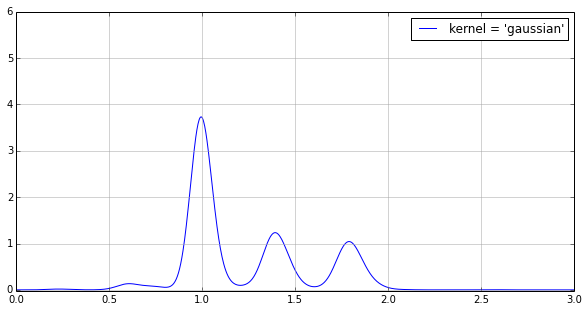

[0.22499999999999998, 0.6060000000000001, 0.99, 1.389, 1.785, 2.55]

In [42]:
X = dfTumorCNV[dfTumorCNV.nonZeroCount>10].ratioOfRatio.sort_values()[:, np.newaxis]
X_range = 3
X_plot = np.linspace(0,X_range,1000)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(X)
log_dens = kde.score_samples(X_plot)
pdfChart(log_dens,6)
cnvPeaks = findPeaks(log_dens,X_range)
cnvPeaks

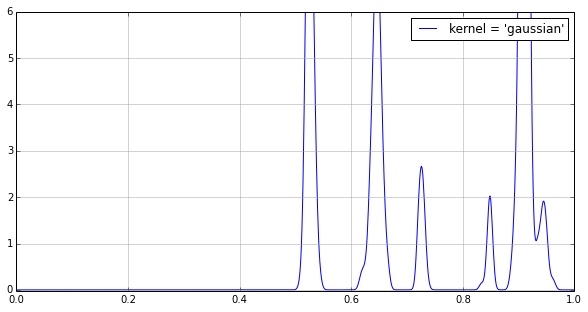

In [46]:
X = dfTumorCNV[dfTumorCNV.mBAFCount>10].mBAF.sort_values()[:, np.newaxis]
X_range = 1
X_plot = np.linspace(0,X_range,1000)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.004).fit(X)
log_dens = kde.score_samples(X_plot)
pdfChart(log_dens,6)
mBAFPeaks = findPeaks(log_dens,X_range)

In [51]:
dfTumorCNV['fittedBAFPeak'] = np.vectorize(fitBAFPeak)(dfTumorCNV['mBAF'])

In [52]:
dfTumorCNV['fittedCNVPeak'] = np.vectorize(fitCNVPeak)(dfTumorCNV['ratioOfRatio'])

In [ ]:
len(dfTumorCNV[(dfTumorCNV.mBAFCount>200)&(dfTumorCNV.nonZeroCount>200)])

In [ ]:
# Assign CNV peak to each segment in dfTumorCNV
# For each unique CNV peak
    # Show the fitted CNV 
    # find mBAF peaks
    # test against purity

### SCRATCH - TUMOR PURITY

In [ ]:
c = 1
fractionMin = 0
fractionMax = 22
dfSom = dfBAF[(dfBAF.chromPos>c+fractionMin)&(dfBAF.chromPos<c+fractionMax)]
plt.figure(figsize=[18,5])
plt.scatter(dfSom.chromPos, dfSom.BAF)
plt.grid(b=True, which='both', color='0.65',linestyle='-')
plt.axis([c+fractionMin, c+fractionMax,0, 1.0])
plt.show()
# CNV according to freeC
plt.figure(figsize=[5,2])
plt.hist(dfTumorCNV['copyNum'].values,cumulative=False, normed=True, bins=20,range=(0,10),weights=dfTumorCNV['regionLength'].values)
plt.show()
# should only use regions with mbaf > x
c,fractionMin,fractionMax = 1,0,22
dftemp = dfTumorCNV[(dfTumorCNV.mBAF>=0.0)&(dfTumorCNV.mBAF<=1.0)&(dfTumorCNV.mBAFCount>20)&(dfTumorCNV.chromPos<=c+fractionMax)&(dfTumorCNV.chromPos>=c+fractionMin)]
plt.figure(figsize=[18,5])
for CNV in range(0,6):
    plt.hist(dftemp[(dftemp.copyNum==CNV)]['mBAF'].values,cumulative=False, normed=False, bins=50,range=(0.5,1.0),weights=dftemp[(dftemp.copyNum==CNV)]['mBAFCount'].values,stacked = True,rwidth=0.8,label='CNV ='+str(CNV))
    plt.legend()
plt.show()

In [ ]:
# get MBAF count
# plot pdf for Ratio
# plot copyNum vs Ratio
